In [2]:
import torch #The torch package contains data structures for multi-dimensional tensors and mathematical operations over these are defined.
import torchvision #The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
import torch_geometric.transforms as T
import pandas as pd

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 25.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 34.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 885.2/885.2 kB 17.5 MB/s eta 0:00:00
Looking in indexes: 

In [4]:
from google.colab import files
uploaded = files.upload()

Saving large_twitch_edges.csv to large_twitch_edges.csv


In [5]:
import io
edge_dataset=pd.read_csv(io.BytesIO(uploaded["large_twitch_edges.csv"]))

In [6]:
from google.colab import files
uploaded = files.upload()

Saving large_twitch_features.csv to large_twitch_features.csv


In [7]:
features_dataset=pd.read_csv(io.BytesIO(uploaded['large_twitch_features.csv']))

In [8]:
# features_dataset = features_dataset.set_index('numeric_id')

In [9]:
# merged_dataset = pd.merge(edge_dataset, features_dataset,left_on='numeric_id_1',right_on='numeric_id')

In [10]:
# merged_dataset = merged_dataset.set_index('numeric_id_1')
# merged_dataset.head()

Converting Dataset to Pytorch Geometric Data

In [11]:
## Language abbrivation to number
languages = ['EN', 'FR', 'KO', 'JA', 'RU', 'PL', 'DE', 'ES', 'IT', 'PT',
       'OTHER', 'TR', 'ZH', 'SV', 'NL', 'TH', 'CS', 'DA', 'HU', 'FI',
       'NO']

from sklearn.preprocessing import LabelEncoder

def encode_df(dataframe):
    le = LabelEncoder()
    features_dataset['language'] = le.fit_transform(features_dataset['language'])
    return dataframe

#encode the dataframe
features_dataset = encode_df(features_dataset)
features_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168114 entries, 0 to 168113
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   views         168114 non-null  int64 
 1   mature        168114 non-null  int64 
 2   life_time     168114 non-null  int64 
 3   created_at    168114 non-null  object
 4   updated_at    168114 non-null  object
 5   numeric_id    168114 non-null  int64 
 6   dead_account  168114 non-null  int64 
 7   language      168114 non-null  int64 
 8   affiliate     168114 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 11.5+ MB


In [12]:
node_features = features_dataset[["numeric_id"]]

In [13]:
# node_features[["created_year", "created_month", "created_day"]] = node_features["created_at"].str.split("-", expand = True).astype('int32')
# node_features[["updated_year", "updated_month", "updated_day"]] = node_features["updated_at"].str.split("-", expand = True).astype('int32')

# node_features = node_features.drop(['created_at','updated_at'],axis=1)

In [14]:
node_features = node_features.astype('float32')
node_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168114 entries, 0 to 168113
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   numeric_id  168114 non-null  float32
dtypes: float32(1)
memory usage: 656.8 KB


In [15]:
x =  torch.from_numpy(node_features.to_numpy())
print(x.shape) # [num_nodes x num_features]
print(x.dtype)

torch.Size([168114, 1])
torch.float32


In [16]:
features_dataset[["dead_account","language","affiliate"]] = features_dataset[["dead_account","language","affiliate"]].astype('int64')
features_dataset[["dead_account","language","affiliate"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168114 entries, 0 to 168113
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   dead_account  168114 non-null  int64
 1   language      168114 non-null  int64
 2   affiliate     168114 non-null  int64
dtypes: int64(3)
memory usage: 3.8 MB


In [17]:
# Select node features
labels = features_dataset[["language"]]
labels.head()

# labels = labels.astype(float)

# Convert to numpy
y =  torch.from_numpy(labels.to_numpy())
y.shape # [num_nodes, 1] --> node regression

torch.Size([168114, 1])

In [18]:
y = y.reshape(-1,)

In [19]:
y.shape

torch.Size([168114])

In [20]:
labels.dtypes

language    int64
dtype: object

In [21]:
edge_dataset = edge_dataset.astype('int64')

In [22]:
edge_dataset = edge_dataset.sort_values(by=['numeric_id_1'])

In [23]:
edge_index = edge_dataset.transpose()

In [24]:
edge_index.dtypes.unique()

array([dtype('int64')], dtype=object)

In [25]:
all_edges =  torch.from_numpy(edge_index.to_numpy()) # [2, num_edges]
print(all_edges.shape)

torch.Size([2, 6797557])


In [26]:
len(features_dataset)

168114

In [27]:
train_arr = np.array([True for i in range(round(len(features_dataset)*0.85))])
train_arr = np.append(train_arr,np.array([False for i in range(int(len(features_dataset)*0.15))]))
train_arr.shape

(168114,)

In [28]:
test_arr = np.array([False for i in range(round(len(features_dataset)*0.55))])
test_arr = np.append(test_arr,np.array([True for i in range(int(len(features_dataset)*0.45))]))
test_arr.shape

(168114,)

In [29]:
val_arr = np.array([False for i in range(round(len(features_dataset)*0.35))])
val_arr = np.append(val_arr,np.array([True for i in range(round(len(features_dataset)*0.35))]))
val_arr = np.append(val_arr,np.array([False for i in range(int(len(features_dataset)*0.30))]))
val_arr.shape

(168114,)

In [30]:
train_mask = torch.from_numpy(train_arr)
test_mask = torch.from_numpy(test_arr)
val_mask = torch.from_numpy(val_arr)

In [31]:
x[:120000].shape

torch.Size([120000, 1])

In [32]:
from torch_geometric.data import Data
data = Data(x=x, edge_index=all_edges, y=y)
train_data = Data(x=x, edge_index=all_edges, y=y)
test_data = Data(x=x, edge_index=all_edges, y=y)
val_data =Data(x=x, edge_index=all_edges, y=y)

In [33]:
data.num_classes = 21
data.train_mask = train_mask
data.test_mask = test_mask
data.val_mask = val_mask

train_data.num_classes = 21
train_data.train_mask = train_mask
train_data.test_mask = test_mask
train_data.val_mask = val_mask

test_data.num_classes = 21
test_data.train_mask = train_mask
test_data.test_mask = test_mask
test_data.val_mask = val_mask

val_data.num_classes = 21
val_data.train_mask = train_mask
val_data.test_mask = test_mask
val_data.val_mask = val_mask

In [34]:
train_edge_label = torch.from_numpy(np.array([1.0 for i in range(round(len(features_dataset)*0.75))]))
test_edge_label = torch.from_numpy(np.append(np.array([1.0 for i in range(round(len(features_dataset)*0.45))]),np.array([0.0 for i in range(round(len(features_dataset)*0.05))])))
val_edge_label = torch.from_numpy(np.append(np.array([1.0 for i in range(round(len(features_dataset)*0.2))]), np.array([0.0 for i in range(round(len(features_dataset)*0.05))])))

In [35]:
# train_edge_label_index = all_edges[:,:len(train_edge_label)]
# test_edge_label_index = all_edges[:,len(train_edge_label):len(train_edge_label)+len(test_edge_label)]
# val_edge_label_index = all_edges[:,len(train_edge_label)+len(test_edge_label):len(train_edge_label)+len(test_edge_label)+len(val_edge_label)]

In [36]:
train_edge_label_index = all_edges[:,:len(train_edge_label)]
test_edge_label_index = all_edges[:,:len(test_edge_label)]
val_edge_label_index = all_edges[:,:len(val_edge_label)]

In [37]:
train_data.edge_label = train_edge_label
train_data.edge_label_index = train_edge_label_index

test_data.edge_label = test_edge_label
test_data.edge_label_index = test_edge_label_index

val_data.edge_label = val_edge_label
val_data.edge_label_index = val_edge_label_index

In [38]:
print(data)
print(train_data)
print(test_data)
print(val_data)

Data(x=[168114, 1], edge_index=[2, 6797557], y=[168114], num_classes=21, train_mask=[168114], test_mask=[168114], val_mask=[168114])
Data(x=[168114, 1], edge_index=[2, 6797557], y=[168114], num_classes=21, train_mask=[168114], test_mask=[168114], val_mask=[168114], edge_label=[126086], edge_label_index=[2, 126086])
Data(x=[168114, 1], edge_index=[2, 6797557], y=[168114], num_classes=21, train_mask=[168114], test_mask=[168114], val_mask=[168114], edge_label=[84057], edge_label_index=[2, 84057])
Data(x=[168114, 1], edge_index=[2, 6797557], y=[168114], num_classes=21, train_mask=[168114], test_mask=[168114], val_mask=[168114], edge_label=[42029], edge_label_index=[2, 42029])


In [39]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

import torch_geometric
print(torch_geometric.__version__)

2.0.0+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.3.0


In [40]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = str(1)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"

In [41]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
# from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
(train_data.edge_index[0] <= train_data.edge_index[1]).sum()

tensor(3407103)

In [66]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        #return the indices of a non-zero element
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [67]:
model = Net(data.num_features, 128, 64).to('cuda')
train_data = train_data.to('cuda')
test_data = test_data.to('cuda')
val_data = val_data.to('cuda')

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [68]:
dataset = data
print(dataset)

Data(x=[168114, 1], edge_index=[2, 6797557], y=[168114], num_classes=21, train_mask=[168114], test_mask=[168114], val_mask=[168114])


In [69]:
# model = Net(dataset.num_features, 128, 64).to(device)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
# criterion = torch.nn.BCEWithLogitsLoss()

In [70]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1))

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())



Epoch: 001, Loss: 2954860035.7604, Val: 0.5000, Test: 0.5000
Epoch: 002, Loss: 993802821.5893, Val: 0.5000, Test: 0.5000
Epoch: 003, Loss: 317442478.2821, Val: 0.5000, Test: 0.5000
Epoch: 004, Loss: 297433141.9572, Val: 0.5000, Test: 0.5000
Epoch: 005, Loss: 396196265.5324, Val: 0.5000, Test: 0.5000
Epoch: 006, Loss: 415817103.1623, Val: 0.5000, Test: 0.5000
Epoch: 007, Loss: 375232352.9493, Val: 0.5000, Test: 0.5000
Epoch: 008, Loss: 314055373.6161, Val: 0.5000, Test: 0.5000
Epoch: 009, Loss: 265335672.7548, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 221364878.4920, Val: 0.5000, Test: 0.5000
Epoch: 011, Loss: 180927974.5033, Val: 0.5000, Test: 0.5000
Epoch: 012, Loss: 142492315.0676, Val: 0.5000, Test: 0.5000
Epoch: 013, Loss: 105333517.3133, Val: 0.5000, Test: 0.5000
Epoch: 014, Loss: 74540042.3340, Val: 0.5000, Test: 0.5000
Epoch: 015, Loss: 52439735.3327, Val: 0.5000, Test: 0.5000
Epoch: 016, Loss: 39278217.2822, Val: 0.5000, Test: 0.5000
Epoch: 017, Loss: 32306827.8182, Val: 0.50

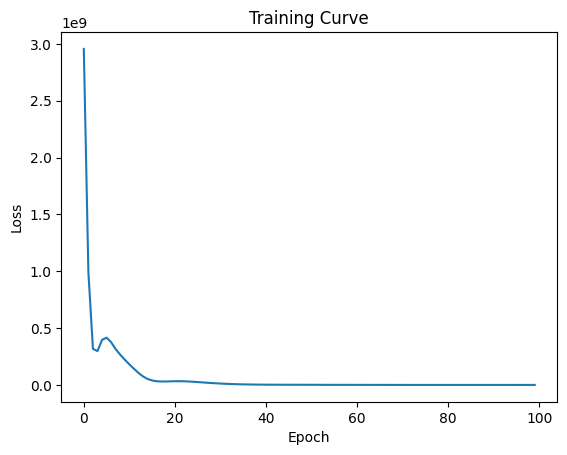

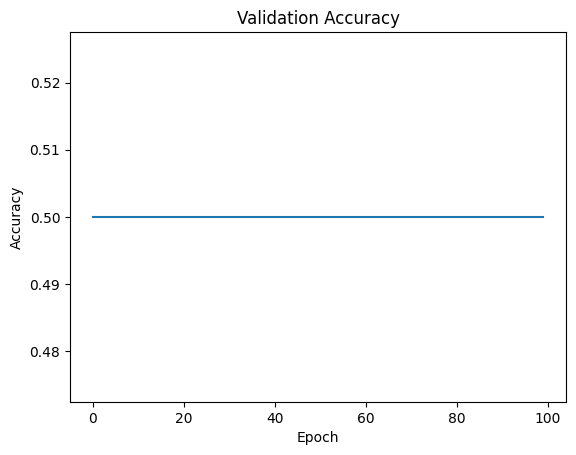

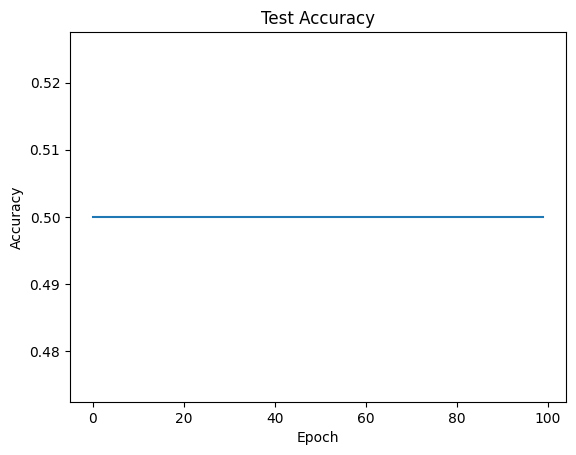

In [71]:
import matplotlib.pyplot as plt

# Create lists to store the training curve and ROC curve data
train_losses = []
val_aucs = []
test_aucs = []

best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    train_losses.append(loss.item())
    val_aucs.append(val_auc)
    test_aucs.append(test_auc)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')


# Plot the training curve
plt.plot(train_losses)
plt.title('Training Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the training curve
plt.plot(val_aucs)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the training curve
plt.plot(test_aucs)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [72]:
# import matplotlib.pyplot as plt

# # Create lists to store the training curve and ROC curve data
# train_losses = []
# val_aucs = []
# test_aucs = []

# best_val_auc = final_test_auc = 0
# for epoch in range(1, 101):
#     loss = train()
#     val_auc = test(val_data)
#     test_auc = test(test_data)
#     if val_auc > best_val_auc:
#         best_val = val_auc
#         final_test_auc = test_auc
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
#           f'Test: {test_auc:.4f}')

# print(f'Final Test: {final_test_auc:.4f}')

In [91]:
torch.cuda.empty_cache()

Graph Sage

In [62]:
class Net_sage(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        #return the indices of a non-zero element
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [63]:
model_sage = Net_sage(data.num_features, 128, 64).to('cuda')
train_data = train_data.to('cuda')
test_data = test_data.to('cuda')
val_data = val_data.to('cuda')

optimizer = torch.optim.Adam(params=model_sage.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [64]:
def train():
    model_sage.train()
    optimizer.zero_grad()
    z = model_sage.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1))

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model_sage.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model_sage.eval()
    z = model_sage.encode(data.x, data.edge_index)
    out = model_sage.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())



Epoch: 001, Loss: 44737445484.4413, Val: 0.5000, Test: 0.5000
Epoch: 002, Loss: 82931779949.2110, Val: 0.5000, Test: 0.5000
Epoch: 003, Loss: 32260436121.6936, Val: 0.5000, Test: 0.5000
Epoch: 004, Loss: 21987069062.8239, Val: 0.5000, Test: 0.5000
Epoch: 005, Loss: 39130815255.0730, Val: 0.5000, Test: 0.5000
Epoch: 006, Loss: 33487223354.0802, Val: 0.5000, Test: 0.5000
Epoch: 007, Loss: 15458566689.2845, Val: 0.4998, Test: 0.5002
Epoch: 008, Loss: 6937200619.6392, Val: 0.5000, Test: 0.5000
Epoch: 009, Loss: 12420825478.8413, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 19590590716.0400, Val: 0.5000, Test: 0.5000
Epoch: 011, Loss: 18382408522.9790, Val: 0.5000, Test: 0.5000
Epoch: 012, Loss: 10805105889.7549, Val: 0.5002, Test: 0.5000
Epoch: 013, Loss: 4434091210.0440, Val: 0.4979, Test: 0.4977
Epoch: 014, Loss: 3608742323.3675, Val: 0.5000, Test: 0.5000
Epoch: 015, Loss: 6723184386.1219, Val: 0.5000, Test: 0.5000
Epoch: 016, Loss: 9240382818.5576, Val: 0.5000, Test: 0.5000
Epoch: 017, L

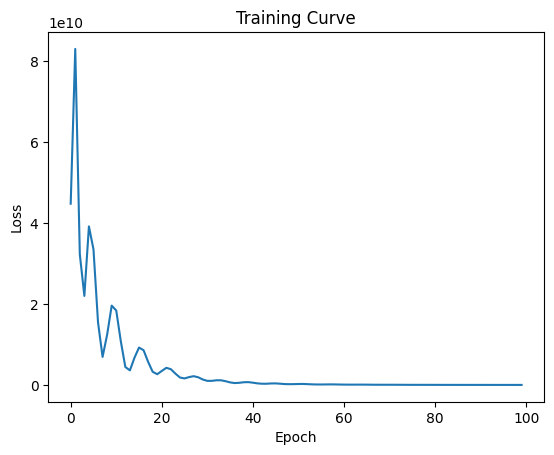

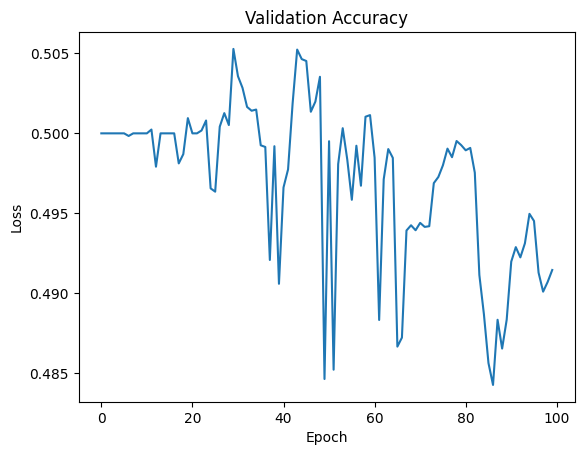

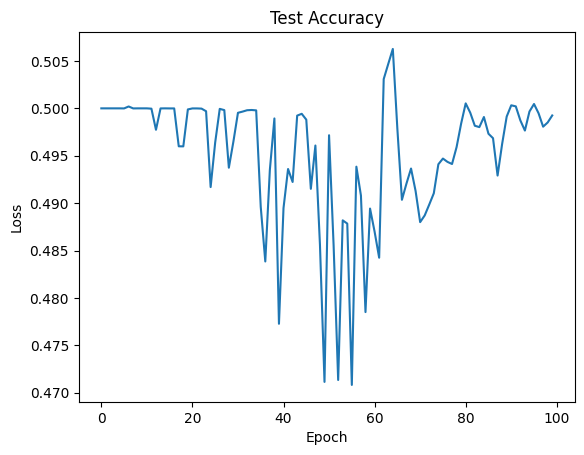

In [65]:
import matplotlib.pyplot as plt

# Create lists to store the training curve and ROC curve data
train_losses = []
val_aucs = []
test_aucs = []

best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    train_losses.append(loss.item())
    val_aucs.append(val_auc)
    test_aucs.append(test_auc)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')


# Plot the training curve
plt.plot(train_losses)
plt.title('Training Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the training curve
plt.plot(val_aucs)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the training curve
plt.plot(test_aucs)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

GAT

In [40]:
class Net_gat(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        #return the indices of a non-zero element
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [42]:
model_gat = Net_gat(data.num_features, 128, 64).to('cpu')
train_data = train_data.to('cpu')
test_data = test_data.to('cpu')
val_data = val_data.to('cpu')

optimizer = torch.optim.Adam(params=model_gat.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [43]:
def train():
    model_gat.train()
    optimizer.zero_grad()
    z = model_gat.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1))

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model_gat.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model_gat.eval()
    z = model_gat.encode(data.x, data.edge_index)
    out = model_gat.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())



In [1]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

NameError: ignored